# Image Captioning using CNN and RNN with Bahdenau Attention
-----------------------------------------------------------------------------------

# Introduction

Image captioning is a challenging area within the field of computer vision that combines elements of image understanding and natural language processing. By generating descriptive text for an image, image captioning systems bridge the gap between visual data and language. This project uses Recurrent Neural Networks (RNN) and Bahdanau Attention, a mechanism that allows the model to dynamically focus on different parts of the image as it generates each word of the caption. This approach addresses the need for models to accurately reflect not just the objects within an image, but also their context and interactions.

## Objectives

1. Develop an image captioning model that effectively combines techniques from both computer vision and natural language processing, utilizing the COCO (Common Objects in Context) dataset.
2. Implement Convolutional Neural Networks (CNNs) to extract meaningful features from images in the COCO dataset, enabling the model to understand the visual content.
3. Utilize Recurrent Neural Networks (RNNs) to generate sequential text for captions, ensuring coherence and grammatical correctness, based on the image features extracted from the COCO dataset.
4. Incorporate Bahdanau Attention mechanism into the model to dynamically focus on different parts of the images from the COCO dataset, enhancing the relevance and detail of the generated captions.
5. Train the model on the COCO dataset, which provides a large collection of images paired with corresponding captions, allowing the model to learn the relationship between visual content and textual descriptions in various contexts.

**Import necessary libraries**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
from PIL import Image
import json
from os import listdir
from os.path import isfile, join
import re
import numpy as np
import time
from glob import glob
from pathlib import Path
import skimage.io as io

In [ ]:
from pycocotools.coco import COCO

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
tf.__version__

'2.15.0'

**Get the images and annotations:**

**coco returns the dictionary of the dataset here we can get id's of images with `coco.getImgIds()` function after getting image id's we have to load those images for loading the images we can use `coco.loadImgs()`:**

In [5]:
dataDir = Path('./coco2017/train2017')
annFile = Path('./coco2017/annotations/person_keypoints_train2017.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])
imgs

loading annotations into memory...
Done (t=7.67s)
creating index...
index created!


[{'license': 3,
  'file_name': '000000516168.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000516168.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-25 21:03:34',
  'flickr_url': 'http://farm3.staticflickr.com/2379/2293730995_e2381ffa38_z.jpg',
  'id': 516168},
 {'license': 4,
  'file_name': '000000547503.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000547503.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2013-11-25 21:20:21',
  'flickr_url': 'http://farm1.staticflickr.com/178/423174638_1c6245ee20_z.jpg',
  'id': 547503},
 {'license': 4,
  'file_name': '000000475546.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000475546.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2013-11-25 21:20:23',
  'flickr_url': 'http://farm1.staticflickr.com/167/423175046_6cd9d0205a_z.jpg',
  'id': 475546}]

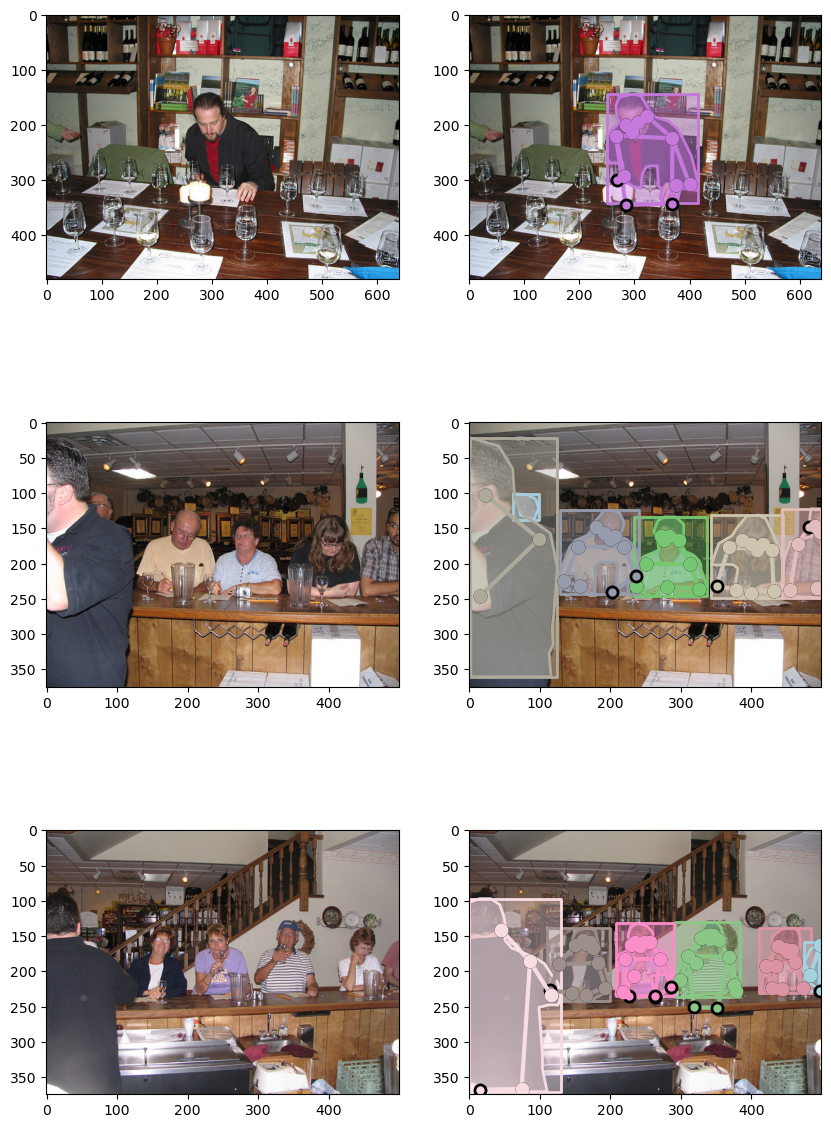

In [6]:
# Create subplots for each image and its corresponding annotations
_, axs = plt.subplots(len(imgs), 2, figsize=(10, 5 * len(imgs)))

# Iterate through each image and its corresponding subplot
for img, ax in zip(imgs, axs):
    # Load the image using its file name and directory
    I = io.imread(dataDir / img['file_name'])
    
    # Get annotation IDs for the current image
    annIds = coco.getAnnIds(imgIds=[img['id']])
    
    # Load annotations for the current image
    anns = coco.loadAnns(annIds)
    
    # Display the image in the first subplot
    ax[0].imshow(I)
    
    # Display the image in the second subplot
    ax[1].imshow(I)
    
    # Set the current axis for annotations display
    plt.sca(ax[1])
    
    # Show annotations on the image with bounding boxes
    coco.showAnns(anns, draw_bbox=True)

How to show just the masks:

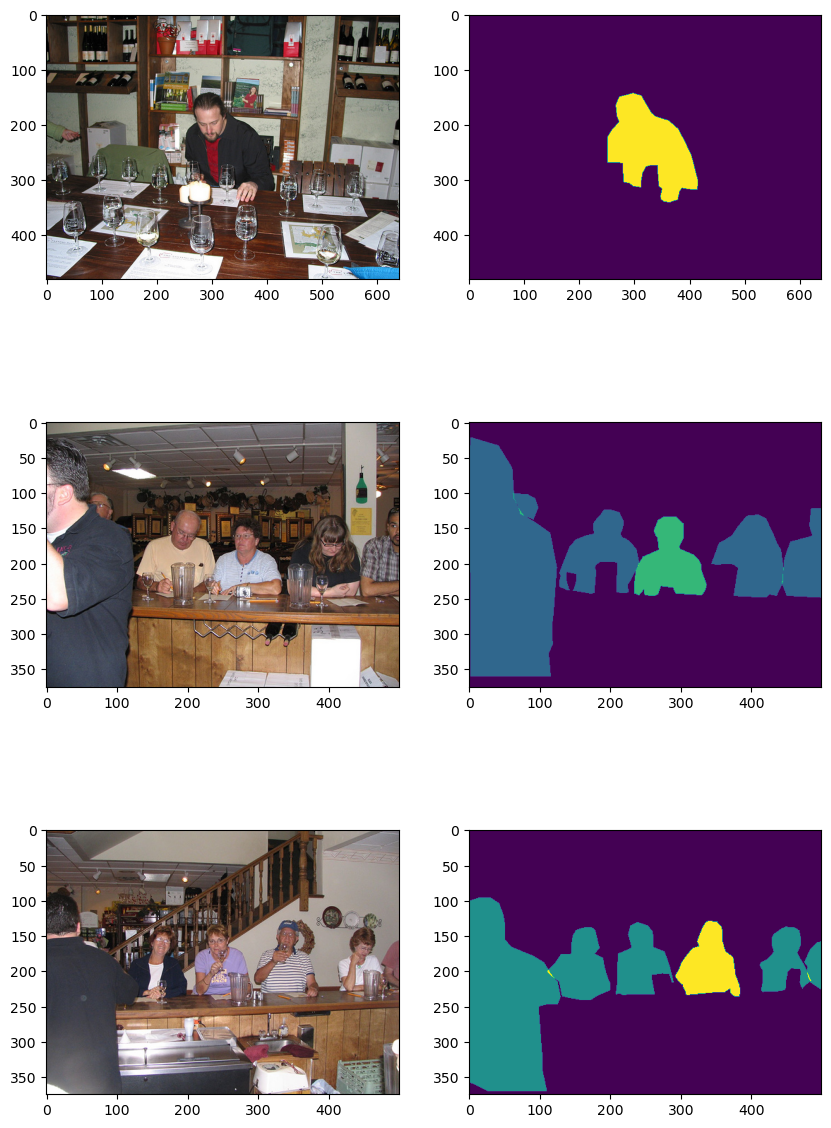

In [7]:
# Create subplots for each image and its corresponding annotation masks
_, axs = plt.subplots(len(imgs), 2, figsize=(10, 5 * len(imgs)))

# Iterate through each image and its corresponding subplot
for img, ax in zip(imgs, axs):
    # Load the image using its file name and directory
    I = io.imread(dataDir / img['file_name'])
    
    # Get annotation IDs for the current image
    annIds = coco.getAnnIds(imgIds=[img['id']])
    
    # Load annotations for the current image
    anns = coco.loadAnns(annIds)
    
    # Display the image in the first subplot
    ax[0].imshow(I)
    
    # Initialize a mask for annotation visualization
    mask = coco.annToMask(anns[0])
    
    # Generate mask for each annotation and add it to the mask
    for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
        
    # Display the mask in the second subplot
    ax[1].imshow(mask)

**Define the path to the directory containing training images from the COCO dataset**

In [8]:
train_images_path = './coco2017/train2017'

**Creating a list of filenames for training images by iterating through the files in the specified directory.**

In [10]:
# Create a list of filenames for training images
filenames_train = [f for f in listdir(train_images_path) if isfile(join(train_images_path, f))]

# Display the first 10 filenames
filenames_train[0:10]

['000000000009.jpg',
 '000000000025.jpg',
 '000000000030.jpg',
 '000000000034.jpg',
 '000000000036.jpg',
 '000000000042.jpg',
 '000000000049.jpg',
 '000000000061.jpg',
 '000000000064.jpg',
 '000000000071.jpg']

**Open and load a JSON file containing annotations for the training images from the COCO dataset.**

In [11]:
# Open the JSON file containing annotations for training images
train_images_file = open('./coco2017/annotations/instances_train2017.json')

# Load the JSON data into a Python dictionary
train_images_json = json.load(train_images_file)

In [12]:
# Iterating through the json
for i in train_images_json['images']:
    #print(i['file_name'])
    print(i)
    break

{'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


**Open and load JSON file, containing captions for the training images from the COCO dataset.**

In [13]:
# Open the JSON file containing captions for training images
train_captions_file = open('./coco2017/annotations/captions_train2017.json')

# Load the JSON data into a Python dictionary
train_captions_json = json.load(train_captions_file)

In [14]:
# Iterating through the json
for i in train_captions_json['annotations']:
    #print(i['file_name'])
    print(i)
    break

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


**Processing the annotations and filenames data loaded from the COCO dataset JSON files to create lists of filenames and corresponding captions for training.**

In [15]:
# Initialize empty lists to store filenames and captions
train_filenames = []
train_captions = []

# Extract filenames and image IDs from the images JSON data
for i in train_images_json['images']:
    train_filenames.append((i['file_name'], i['id']))

# Extract image IDs and captions from the captions JSON data
for i in train_captions_json['annotations']:
    train_captions.append((i['image_id'], i['caption']))

# Create dictionaries mapping image IDs to filenames and image IDs to captions
ids_files = dict()
for i in train_filenames:
    ids_files[i[1]] = i[0]

ids_captions = dict()
for i in train_captions:
    ids_captions[i[0]] = i[1]

# Populate lists with filenames and captions based on image IDs
train_filenames = []
train_captions = []
for k, v in ids_files.items():
    train_filenames.append(v)
    train_captions.append(ids_captions[k])

# Display the first 10 pairs of filenames and captions
list(zip(train_filenames[:10], train_captions[:10]))

[('000000391895.jpg',
  'A man in a red shirt and a red hat is on a motorcycle on a hill side.'),
 ('000000522418.jpg',
  "A woman marking a cake with the back of a chef's knife. "),
 ('000000184613.jpg',
  'A boy holding an umbrella while standing next to livestock.'),
 ('000000318219.jpg', 'a young kid with head phones on using a computer '),
 ('000000554625.jpg',
  'A small child wearing headphones plays on the computer.'),
 ('000000574769.jpg', 'A woman is holding a cat in her kitchen.'),
 ('000000060623.jpg',
  'A little girl is getting ready to blow out a candle on a small dessert.'),
 ('000000309022.jpg', 'Food cooks in a pot on a stove in a kitchen.'),
 ('000000005802.jpg', 'two men in white shirts in a large steel kitchen'),
 ('000000222564.jpg',
  'Two cooks are near the stove in a stainless steel kitchen.')]

In [16]:
len(train_filenames), len(train_captions)

(118287, 118287)

**Function to load an image from a given file path**

In [17]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
        
    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

**Function to load and plot an image from either the training or validation set, depending on the value of the train parameter.**

In [18]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    
    Args:
    - idx: Index of the image to be displayed.
    - train: Boolean indicating whether to load the image from the training set (True) or validation set (False).
    """
    
    # Determine whether to load from training or validation set
    if train:
        filename = train_filenames[idx]
        caption = train_captions[idx]
    else:
        filename = val_filenames[idx]
        caption = val_captions[idx]

    # Construct the full path to the image file
    path = os.path.join(train_images_path, filename)

    # Print the caption associated with the image
    print(caption)
    
    # Load the image and plot it
    img = load_image(path)
    plt.imshow(img)
    plt.show()

## Example Image
**Show an example image and captions from the training-set.**

In [19]:
train_filenames[1], train_captions[1]

('000000522418.jpg',
 "A woman marking a cake with the back of a chef's knife. ")

A woman marking a cake with the back of a chef's knife. 


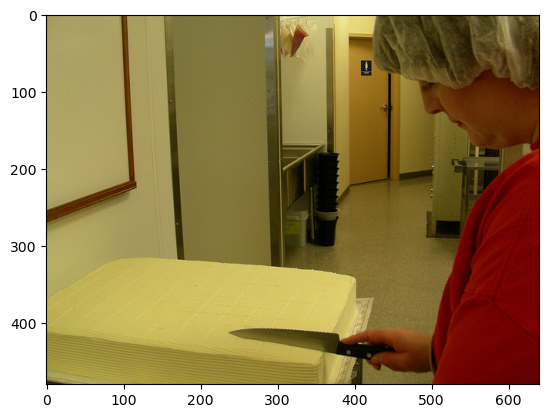

In [20]:
show_image(idx=1, train=True)

# 1. Preprocessing the images using Inception V3
**Let's use InceptionV3 (which is pretrained on [Imagenet](http://www.image-net.org/)) to classify each image. We'll also extract features from the last convolutional layer.**

In [21]:
len(train_filenames), len(train_captions)

(118287, 118287)

**Creating a smaller subset of your training data by selecting the first 40,000 filenames and captions from your original dataset.**

In [22]:
train_filenames_mini = train_filenames[0:40000]
train_captions_mini = train_captions[0:40000]

**Creating a `list img_name_vector` containing the file paths of images from training dataset.**

In [23]:
# Initialize an empty list to store the file paths of training images
img_name_vector = []

# Assign the smaller subset of training captions to the variable train_captions
train_captions = train_captions_mini

# Iterate over the indices of the smaller subset of training filenames
for i in range(len(train_filenames_mini)):
    img_name_vector.append('./coco2017/train2017/' + train_filenames_mini[i])

In [24]:
train_captions

['A man in a red shirt and a red hat is on a motorcycle on a hill side.',
 "A woman marking a cake with the back of a chef's knife. ",
 'A boy holding an umbrella while standing next to livestock.',
 'a young kid with head phones on using a computer ',
 'A small child wearing headphones plays on the computer.',
 'A woman is holding a cat in her kitchen.',
 'A little girl is getting ready to blow out a candle on a small dessert.',
 'Food cooks in a pot on a stove in a kitchen.',
 'two men in white shirts in a large steel kitchen',
 'Two cooks are near the stove in a stainless steel kitchen.',
 'A dim lit room consisting of many objects put together. ',
 'A kitchen with wooden cabinets and black appliances.',
 'A cluttered room with a sink, a toilet and in industrial mop bucket.',
 'A man riding a bike past a train traveling along tracks.',
 'The pantry door of the small kitchen is closed.',
 'A full view of an open kitchen and dining area.',
 'A woman eating fresh vegetables from a bowl

In [25]:
img_name_vector

['./coco2017/train2017/000000391895.jpg',
 './coco2017/train2017/000000522418.jpg',
 './coco2017/train2017/000000184613.jpg',
 './coco2017/train2017/000000318219.jpg',
 './coco2017/train2017/000000554625.jpg',
 './coco2017/train2017/000000574769.jpg',
 './coco2017/train2017/000000060623.jpg',
 './coco2017/train2017/000000309022.jpg',
 './coco2017/train2017/000000005802.jpg',
 './coco2017/train2017/000000222564.jpg',
 './coco2017/train2017/000000118113.jpg',
 './coco2017/train2017/000000193271.jpg',
 './coco2017/train2017/000000224736.jpg',
 './coco2017/train2017/000000483108.jpg',
 './coco2017/train2017/000000403013.jpg',
 './coco2017/train2017/000000374628.jpg',
 './coco2017/train2017/000000328757.jpg',
 './coco2017/train2017/000000384213.jpg',
 './coco2017/train2017/000000293802.jpg',
 './coco2017/train2017/000000086408.jpg',
 './coco2017/train2017/000000372938.jpg',
 './coco2017/train2017/000000386164.jpg',
 './coco2017/train2017/000000223648.jpg',
 './coco2017/train2017/00000020480

In [26]:
len(train_captions), len(img_name_vector)

(40000, 40000)

In [27]:
train_captions[0], img_name_vector[0]

('A man in a red shirt and a red hat is on a motorcycle on a hill side.',
 './coco2017/train2017/000000391895.jpg')

**So we need to convert the images into InceptionV3's expected format by resizing the images to 299 pixels by 299 pixels.**

In [28]:
def load_image(image_path):
    """
    Load and preprocess an image from the given file path.

    Args:
    - image_path: File path to the image.

    Returns:
    - img: Preprocessed image as a TensorFlow tensor.
    - image_path: The input image path.
    """
    # Read image file as a tensor
    img = tf.io.read_file(image_path)
    
    # Decode JPEG-encoded image and ensure 3 color channels
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize image to 299x299 pixels
    img = tf.image.resize(img, (299, 299))
    
    # Preprocess image for Inception V3 model
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path

**Let's instantiate a new image model with Inception V3. You will see it has an order of magnitude less trainable parameters.**

**We'll create a `tf.keras` model where the output layer is the last convolutional layer in the InceptionV3 architecture.** 

**The shape of the output of this layer is 8x8x2048. We will use the last convolutional layer, and won't perform  initialization during training because it can become a bottleneck.**

**We will forward each image through the Inception V3 network and store the resulting vector in a dictionary (image_name --> feature_vector). After all the images are passed through the network, we'll pickle the dictionary and save it to disk.**

**If you run the cell below for the first time, it will take a bit of time to download the Inception network weights. The, you'll have them for reruns.**

In [29]:
# Load the InceptionV3 model pretrained on ImageNet dataset
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Get the input tensor of the InceptionV3 model
new_input = image_model.input

# Get the output tensor from the last convolutional layer of the InceptionV3 model
hidden_layer = image_model.layers[-1].output

# Create a new model that takes the input tensor of InceptionV3 model and outputs the output tensor
# from the last convolutional layer
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

In [30]:
image_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

**Let's run all our images through Inception to generate each image's **thought vector**, and store each in an `.npy` file.**

**We are going to read images into Inception in batches. I use batch number 64.**

**We are going to use a different caching strategy than before:**

In [31]:
len(img_name_vector), img_name_vector[0]

(40000, './coco2017/train2017/000000391895.jpg')

In [32]:
# Get unique images
#encode_train = sorted(set(img_name_vector))
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [33]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [34]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    print(batch_features.shape)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    print(batch_features.shape)
    break

  0%|          | 0/625 [00:00<?, ?it/s]  0%|          | 0/625 [00:03<?, ?it/s]

(64, 8, 8, 2048)
(64, 64, 2048)


In [35]:
image_features_extract_model(img)

<tf.Tensor: shape=(64, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.54202008e-01, 0.00000000e+00, ...,
          0.00000000e+00, 1.61198926e+00, 3.85629619e-03],
         [0.00000000e+00, 0.00000000e+00, 8.12242031e-02, ...,
          0.00000000e+00, 1.05909336e+00, 4.64349270e-01],
         [0.00000000e+00, 0.00000000e+00, 1.12880081e-01, ...,
          0.00000000e+00, 9.32131529e-01, 1.07680154e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 2.65147448e-01, 3.34829241e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 1.21991280e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 7.34837532e-01, ...,
          2.18122229e-01, 1.30832887e+00, 0.00000000e+00],
         [0.00000000e+00, 1.18025392e-01, 1.75414050e+00, ...,
         

**Extract image features using the previously defined image_features_extract_model and save them as NumPy arrays (.npy files) for each image in the dataset.**

In [60]:
from tqdm import tqdm

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        new_path_of_feature = path_of_feature[0:path_of_feature.rindex('/')] + '.npy' + path_of_feature[path_of_feature.rindex('/'):]
        np.save(new_path_of_feature, bf.numpy())

100%|██████████| 625/625 [38:24<00:00,  3.69s/it]


# 2.Preprocess and tokenize the captions
**First, we tokenize the captions by splitting on spaces.** 

**This gives us a vocabulary of all of the unique words in the target language (`surfing`, `football`, etc.).**

**Next, we limit the vocabulary size to the top 1,000 words (to save memory). We replace all other words with the token "UNK" (unknown).**

**We then create word-to-index and index-to-word mappings, and pad all sequences to be the same length as the longest one.**

In [36]:
len(train_captions), len(img_name_vector)

(40000, 40000)

In [37]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

**Add the start and end tokens:**

In [38]:
train_captions_wrapped = []
for c in train_captions:
    train_captions_wrapped.append('<start> ' + c + ' <end>')
    
train_captions_wrapped[0]

'<start> A man in a red shirt and a red hat is on a motorcycle on a hill side. <end>'

In [39]:
# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions_wrapped)
train_seqs = tokenizer.texts_to_sequences(train_captions_wrapped)

In [40]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [41]:
len(train_captions_wrapped), train_captions_wrapped[500], 

(40000,
 '<start> Pancakes on a plate with banana, sauce and whipped cream toppings <end>')

Let's create our tokenized vectors

In [42]:
train_seqs = tokenizer.texts_to_sequences(train_captions_wrapped)

In [43]:
train_seqs

[[3, 2, 12, 8, 2, 50, 175, 10, 2, 50, 278, 11, 5, 2, 120, 5, 2, 228, 65, 4],
 [3, 2, 23, 4191, 2, 117, 9, 6, 184, 7, 2, 5446, 395, 4],
 [3, 2, 82, 29, 14, 131, 57, 20, 22, 13, 2521, 4],
 [3, 2, 52, 459, 9, 235, 640, 5, 290, 2, 112, 4],
 [3, 2, 38, 149, 93, 1275, 626, 5, 6, 112, 4],
 [3, 2, 23, 11, 29, 2, 48, 8, 87, 59, 4],
 [3, 2, 147, 91, 11, 296, 211, 13, 1354, 88, 2, 1147, 5, 2, 38, 856, 4],
 [3, 64, 1723, 8, 2, 641, 5, 2, 261, 8, 2, 59, 4],
 [3, 16, 89, 8, 21, 1276, 8, 2, 30, 698, 59, 4],
 [3, 16, 1723, 17, 39, 6, 261, 8, 2, 977, 698, 59, 4],
 [3, 2, 2522, 492, 44, 1652, 7, 125, 1277, 1026, 143, 4],
 [3, 2, 59, 9, 109, 446, 10, 36, 665, 4],
 [3, 2, 770, 44, 9, 2, 116, 2, 79, 10, 8, 1117, 2785, 1246, 4],
 [3, 2, 12, 53, 2, 248, 401, 2, 35, 356, 217, 187, 4],
 [3, 6, 2786, 284, 7, 6, 38, 59, 11, 796, 4],
 [3, 2, 210, 172, 7, 14, 132, 59, 10, 429, 97, 4],
 [3, 2, 23, 113, 611, 197, 96, 2, 166, 4],
 [3, 271, 10, 566, 17, 490, 39, 2, 59, 116, 4],
 [3, 2, 426, 1917, 34, 121, 5, 2, 24, 4]

We now pad each vector to the max_length of the captions.

In [44]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [45]:
cap_vector

array([[  3,   2,  12, ...,   0,   0,   0],
       [  3,   2,  23, ...,   0,   0,   0],
       [  3,   2,  82, ...,   0,   0,   0],
       ...,
       [  3,  16, 234, ...,   0,   0,   0],
       [  3,  14, 133, ...,   0,   0,   0],
       [  3,   2, 156, ...,   0,   0,   0]])

In [46]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

46

In [47]:
len(cap_vector[0]), cap_vector[0]

(46,
 array([  3,   2,  12,   8,   2,  50, 175,  10,   2,  50, 278,  11,   5,
          2, 120,   5,   2, 228,  65,   4,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]))

# 3. Training and Validation Split

In [48]:
len(img_name_vector), len(cap_vector)

(40000, 40000)

In [49]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.1,
                                                                    random_state=42)

In [50]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(36000, 36000, 4000, 4000)

In [51]:
img_name_train[400:402], tokenizer.sequences_to_texts(cap_train[400:402])

(['./coco2017/train2017/000000434637.jpg',
  './coco2017/train2017/000000085340.jpg'],
 ['<start> a man on a surfboard in front of a small wave <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>',
  '<start> a man and two women holding a basket with a hotdog <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'])

# 4. Creating a `tf.data` dataset for training
Let's create a `tf.data` dataset to use for training our model.

In [52]:
# You can change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [53]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    name = img_name.decode('utf-8')
    new_name = name[0:name.rindex('/')] + '.npy' + name[name.rindex('/'):] + '.npy'
    img_tensor = np.load(new_name)
    return img_tensor, cap

In [54]:
len(img_name_train), len(cap_train)

(36000, 36000)

In [55]:
img_name_train

['./coco2017/train2017/000000376358.jpg',
 './coco2017/train2017/000000090991.jpg',
 './coco2017/train2017/000000554100.jpg',
 './coco2017/train2017/000000413709.jpg',
 './coco2017/train2017/000000271907.jpg',
 './coco2017/train2017/000000219174.jpg',
 './coco2017/train2017/000000422424.jpg',
 './coco2017/train2017/000000053058.jpg',
 './coco2017/train2017/000000279256.jpg',
 './coco2017/train2017/000000485943.jpg',
 './coco2017/train2017/000000359659.jpg',
 './coco2017/train2017/000000397734.jpg',
 './coco2017/train2017/000000280607.jpg',
 './coco2017/train2017/000000208740.jpg',
 './coco2017/train2017/000000230780.jpg',
 './coco2017/train2017/000000201111.jpg',
 './coco2017/train2017/000000383270.jpg',
 './coco2017/train2017/000000348059.jpg',
 './coco2017/train2017/000000391603.jpg',
 './coco2017/train2017/000000452622.jpg',
 './coco2017/train2017/000000172094.jpg',
 './coco2017/train2017/000000553747.jpg',
 './coco2017/train2017/000000381106.jpg',
 './coco2017/train2017/00000047109

In [56]:
cap_train

array([[   3,  115, 1018, ...,    0,    0,    0],
       [   3,   12, 3202, ...,    0,    0,    0],
       [   3,    2,  136, ...,    0,    0,    0],
       ...,
       [   3,    2,   31, ...,    0,    0,    0],
       [   3,    2,  491, ...,    0,    0,    0],
       [   3,    2,   21, ...,    0,    0,    0]])

In [57]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [58]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

# 5. Bahdenau Attention Model

We will use a Bahdanau Attention model (a.k.a. *additive Attention*) decoder. The model architecture is from [here](https://arxiv.org/pdf/1502.03044.pdf).

The architecture of a Bahdanau Attention model for image captioning.

**Feature Extraction from InceptionV3:**
- Features are extracted from the last convolutional layer of the InceptionV3 model.
- The resulting feature map has a shape of (8, 8, 2048).
- This feature map is reshaped to (64, 2048) to flatten it.

**CNN Encoder:**
- A single fully connected layer is used as the CNN Encoder.
- This layer processes the flattened feature map to produce encoded features, which act as the initial hidden state for the RNN.

**Bahdanau Attention Mechanism:**
- A GRU (Gated Recurrent Unit) RNN is used to attend over the image and predict the next word in the caption.
- The Bahdanau Attention mechanism is applied to the encoded features from the CNN Encoder and the hidden states of the RNN.
- This attention mechanism helps the model focus on different parts of the image while generating captions.

Here's a high-level overview of the Bahdanau Attention model architecture:

- **Input:** Encoded features from the InceptionV3 model.
- **Encoder:** A single fully connected layer.
- **Decoder:** A GRU RNN with Bahdanau Attention.
- **Output:** Predicted captions for the given images.

**Bahdanau Attention layer**

In [59]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # Initialize the trainable parameters for the attention mechanism
        self.W1 = tf.keras.layers.Dense(units)  # Dense layer for transforming input features
        self.W2 = tf.keras.layers.Dense(units)  # Dense layer for transforming hidden states
        self.V = tf.keras.layers.Dense(1)       # Dense layer for generating attention scores

    def call(self, features, hidden):
        # Expand the dimensions of the hidden state to match the shape of features
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # Calculate the attention scores using a tanh activation function
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # Apply a softmax activation to obtain attention weights
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Calculate the context vector by element-wise multiplication with attention weights
        context_vector = attention_weights * features
        
        # Reduce the context vector along the sequence dimension to obtain the weighted sum
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [60]:
embedding_dim

256

**CNN Encoder class**

In [61]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # Define a fully connected layer to process the extracted features
        # The shape after the fully connected layer will be (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # Pass the input through the fully connected layer
        x = self.fc(x)
        # Apply ReLU activation function to introduce non-linearity
        x = tf.nn.relu(x)
        return x

**RNN Decoder class**

In [62]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        # Embedding layer to convert token IDs into dense vectors of fixed size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # GRU (Gated Recurrent Unit) layer for recurrent processing
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        # Fully connected layers for output projection
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Bahdanau Attention mechanism
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # Attention mechanism to obtain context vector and attention weights
        context_vector, attention_weights = self.attention(features, hidden)

        # Embedding layer to convert token IDs into dense vectors
        x = self.embedding(x)

        # Concatenate context vector with embedded input
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Pass concatenated vector through GRU
        output, state = self.gru(x)

        # Fully connected layer to project GRU output
        x = self.fc1(output)

        # Reshape for final fully connected layer
        x = tf.reshape(x, (-1, x.shape[2]))

        # Final output logits for each token in the vocabulary
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

**Let's instantiate our encoder and decoder:**

In [63]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

**Optimizer and loss function:**

In [64]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

**Let's checkpoint.**

In [65]:
# Directory to save checkpoints
checkpoint_path = './checkpoints/bahdanau'

# Create a tf.train.Checkpoint object to save and restore model states
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)

# Create a tf.train.CheckpointManager to manage checkpoint files
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [66]:
# Initialize start_epoch variable
start_epoch = 0

# Check if there is a latest checkpoint available
if ckpt_manager.latest_checkpoint:
    # Extract the epoch number from the latest checkpoint filename
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    
    # Restore the model and optimizer states from the latest checkpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)

**Let's write our training step.**

**We extract the features stored in the respective .npy files and then pass those features through the encoder.**

**The encoder output, hidden state (initialized to 0) and the decoder input (which is the start token) is passed to the decoder.**

**The decoder returns the predictions and the decoder hidden state.**

**The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.**

**We use **teacher forcing** to decide the next input to the decoder (the technique where the target word is passed as the next input to the decoder).**

**The final step is to calculate the gradients and apply it to the optimizer and backpropagate!**

**We add the next cell in a separate cell because if we rerun the training cell in order to keep on training, 
the loss_plot array will be reset!**

In [67]:
loss_plot = []

Prototyping and checking our dimensions

In [68]:
for (batch, (img_tensor, target)) in enumerate(dataset):
    # Print shapes of input image tensor and target caption tensor
    print('img_tensor, target:', img_tensor.shape, target.shape)
    
    # Reset the decoder hidden state
    hidden = decoder.reset_state(batch_size=target.shape[0])
    print('hidden:', hidden.shape)
    
    # Initialize decoder input with start token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    print('dec_input:', dec_input.shape)
    
    # Extract features from the encoder
    features = encoder(img_tensor)
    print('features', features.shape)
    
    # Pass input to the decoder and get predictions, new hidden state, and attention weights
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    print('predictions, hidden, junk:', predictions.shape, hidden.shape, junk.shape)
    
    # Compute loss between predicted token and actual token
    print('target[:, 1]:', target[:, 1].shape)
    loss = loss_function(target[:, 1], predictions)
    print('loss:', loss.numpy())
    
    # Update decoder input with current target token for teacher forcing
    dec_input = tf.expand_dims(target[:, 1], 1)
    print('dec_input:', dec_input.shape)
    
    # Break the loop after one iteration (for demonstration purposes)
    break

img_tensor, target: (64, 64, 2048) (64, 46)
hidden: (64, 512)
dec_input: (64, 1)
features (64, 64, 256)
predictions, hidden, junk: (64, 10001) (64, 512) (64, 64, 1)
target[:, 1]: (64,)
loss: 1.23054
dec_input: (64, 1)


**The function is decorated with @tf.function to create a TensorFlow graph for faster execution.**

**It initializes the hidden state of the decoder for each batch since captions are not related between images.**

**It initializes the decoder input with the start token.**

**Within the tf.GradientTape context, it computes predictions from the decoder for each token in the target sequence and calculates the loss.**

**Teacher forcing is used to determine the next input to the decoder.**

**It computes gradients and applies them to update the trainable variables of the encoder and decoder using the optimizer.**

**It returns both the total loss and the loss for logging and monitoring purposes.**

In [69]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialize the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialize the decoder input with the start token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    # Use tf.GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Extract features from the encoder
        features = encoder(img_tensor)

        # Iterate through each token in the target sequence
        for i in range(1, target.shape[1]):
            # Pass the features, hidden state, and decoder input to the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # Calculate the loss between the predicted token and the actual token
            loss += loss_function(target[:, i], predictions)

            # Use teacher forcing: the next input to the decoder is the current target token
            dec_input = tf.expand_dims(target[:, i], 1)

    # Calculate the average loss
    total_loss = (loss / int(target.shape[1]))

    # Get trainable variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute gradients
    gradients = tape.gradient(loss, trainable_variables)

    # Apply gradients to optimizer and update weights
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Now we're ready for our training loop.

In [97]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2473
Epoch 1 Batch 100 Loss 1.3201
Epoch 1 Batch 200 Loss 1.1791
Epoch 1 Batch 300 Loss 1.0579
Epoch 1 Batch 400 Loss 0.9839
Epoch 1 Batch 500 Loss 0.9247
Epoch 1 Loss 1.105143
Time taken for 1 epoch 1218.1770601272583 sec

Epoch 2 Batch 0 Loss 0.8368
Epoch 2 Batch 100 Loss 0.8560
Epoch 2 Batch 200 Loss 0.9406
Epoch 2 Batch 300 Loss 0.9365
Epoch 2 Batch 400 Loss 0.8649
Epoch 2 Batch 500 Loss 0.8098
Epoch 2 Loss 0.845396
Time taken for 1 epoch 1415.140487909317 sec

Epoch 3 Batch 0 Loss 0.7887
Epoch 3 Batch 100 Loss 0.7882
Epoch 3 Batch 200 Loss 0.8390
Epoch 3 Batch 300 Loss 0.7087
Epoch 3 Batch 400 Loss 0.7573
Epoch 3 Batch 500 Loss 0.7124
Epoch 3 Loss 0.769408
Time taken for 1 epoch 1143.0554056167603 sec

Epoch 4 Batch 0 Loss 0.7413
Epoch 4 Batch 100 Loss 0.8170
Epoch 4 Batch 200 Loss 0.7398
Epoch 4 Batch 300 Loss 0.6728
Epoch 4 Batch 400 Loss 0.7606
Epoch 4 Batch 500 Loss 0.6877
Epoch 4 Loss 0.720247
Time taken for 1 epoch 1112.0013065338135 sec

Epoch 5 Batch

Let's plot our training loss throughout our training:

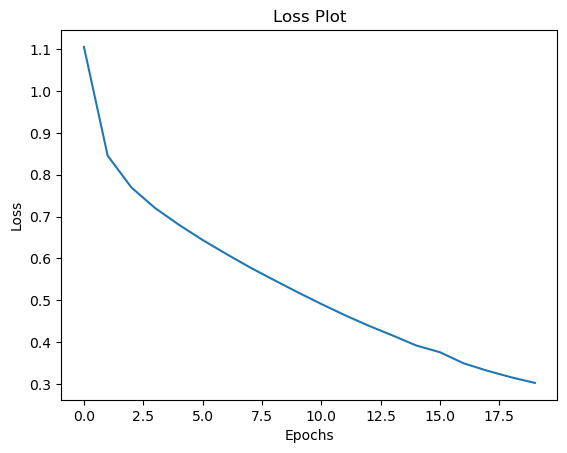

In [98]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Let's continue for another 12 epochs! We're doing good!

In [117]:
EPOCHS = 12

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = `train_step`(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2218
Epoch 1 Batch 100 Loss 0.2932
Epoch 1 Batch 200 Loss 0.2649
Epoch 1 Batch 300 Loss 0.2981
Epoch 1 Batch 400 Loss 0.2485
Epoch 1 Batch 500 Loss 0.2768
Epoch 1 Loss 0.282042
Time taken for 1 epoch 1145.1114568710327 sec

Epoch 2 Batch 0 Loss 0.3165
Epoch 2 Batch 100 Loss 0.2690
Epoch 2 Batch 200 Loss 0.2835
Epoch 2 Batch 300 Loss 0.2490
Epoch 2 Batch 400 Loss 0.2997
Epoch 2 Batch 500 Loss 0.2462
Epoch 2 Loss 0.271755
Time taken for 1 epoch 1144.6070408821106 sec

Epoch 3 Batch 0 Loss 0.2477
Epoch 3 Batch 100 Loss 0.2708
Epoch 3 Batch 200 Loss 0.2746
Epoch 3 Batch 300 Loss 0.2981
Epoch 3 Batch 400 Loss 0.2787
Epoch 3 Batch 500 Loss 0.2350
Epoch 3 Loss 0.260467
Time taken for 1 epoch 1347.5530622005463 sec

Epoch 4 Batch 0 Loss 0.2779
Epoch 4 Batch 100 Loss 0.2657
Epoch 4 Batch 200 Loss 0.2309
Epoch 4 Batch 300 Loss 0.2698
Epoch 4 Batch 400 Loss 0.2685
Epoch 4 Batch 500 Loss 0.2371
Epoch 4 Loss 0.250985
Time taken for 1 epoch 2718.2239978313446 sec

Epoch 5 Batc

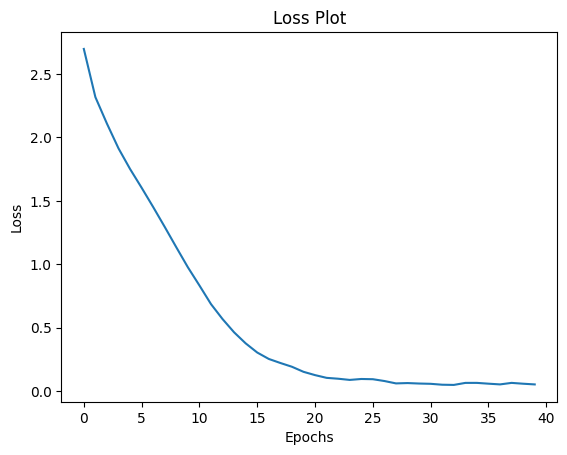

In [285]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# 6. Inference

So now we're ready for inference, that is, to translate *any* image to text!

The evaluate function is similar to the training loop, except we don't use **teacher forcing**. 

The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.

We stop predicting when the model predicts the end sentinel `<end>`.

We store attention weights at every time step.

**The evaluate function is for generating captions for a given image.**

In [69]:
def evaluate(image):
    # Initialize the attention plot matrix
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Reset the hidden state of the decoder
    hidden = decoder.reset_state(batch_size=1)

    # Preprocess the image and extract features using the image_features_extract_model
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Encode the image features
    features = encoder(img_tensor_val)

    # Initialize the decoder input with the start token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    # Iterate through each token in the caption sequence
    for i in range(max_length):
        # Pass the features, hidden state, and decoder input to the decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Store the attention weights for visualization
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Sample the next token using categorical distribution
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        # Convert the predicted token ID to its corresponding word
        result.append(tokenizer.index_word[predicted_id])

        # If the predicted word is <end>, return the result
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        # Update the decoder input with the predicted token for the next iteration
        dec_input = tf.expand_dims([predicted_id], 0)

    # Truncate the attention plot matrix to match the length of the generated caption
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

**The `plot_attention` function is for visualizing the attention weights over the input image along with the generated caption.**

In [70]:
def plot_attention(image, result, attention_plot):
    # Load the input image
    temp_image = np.array(Image.open(image))

    # Create a new figure for plotting
    fig = plt.figure(figsize=(10, 10))

    # Iterate through each word in the generated caption
    len_result = len(result)
    for l in range(len_result):
        # Resize the attention weights to match the image size
        temp_att = np.resize(attention_plot[l], (8, 8))

        # Add a subplot for each word
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        
        # Set the title of the subplot to the corresponding word in the caption
        ax.set_title(result[l])
        
        # Display the input image
        img = ax.imshow(temp_image)
        
        # Overlay the attention weights on the image
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    # Adjust the layout of the subplots to fit the figure
    plt.tight_layout()
    
    # Show the plot
    plt.show()

**Let's select an image at random from our evaluation dataset, translate it, and compare translation with the original caption:**

In [71]:
len(img_name_val)

4000

In [72]:
img_name_val[10]

'./coco2017/train2017/000000015140.jpg'

In [73]:
cap_val[10]

array([   3,    2,   23,    8,  182, 1010,    2,   21,   48,   10,  351,
         31,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

In [74]:
' '.join([tokenizer.index_word[i] for i in cap_val[10] if i not in [0]])

'<start> a woman in orange pants a white cat and sleeping person <end>'

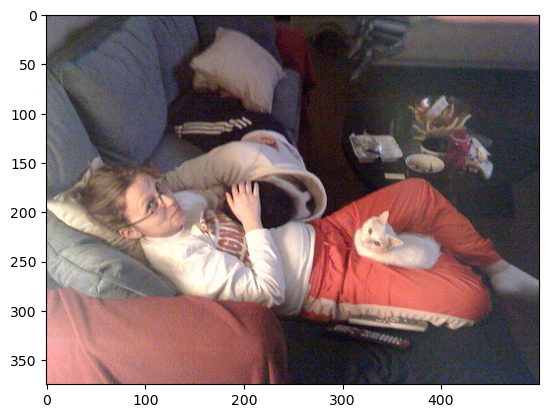

In [75]:
img = img_name_val[10]
img = Image.open(img)
img = np.array(img)
img = img / 255.0
plt.imshow(img)

Real Caption: <start> a woman in orange pants a white cat and sleeping person <end>
Prediction Caption: a group sleeping on a couch next to the table <end>


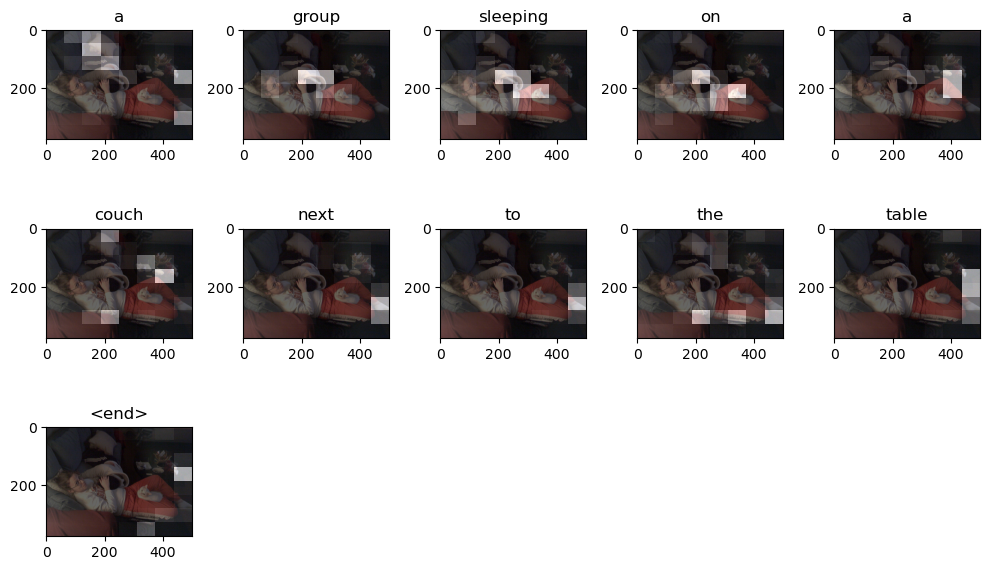

./coco2017/train2017/000000015140.jpg


In [76]:
# captions on the validation set
#rid = np.random.randint(0, len(img_name_val))
#image = img_name_val[rid]
image = img_name_val[10]
#rea1l_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[10] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
print(image)

**Let's find a picture on the Web of two dogs playing on the beach, and translate it:**

Prediction caption: a dog on the beach next to the water <end>


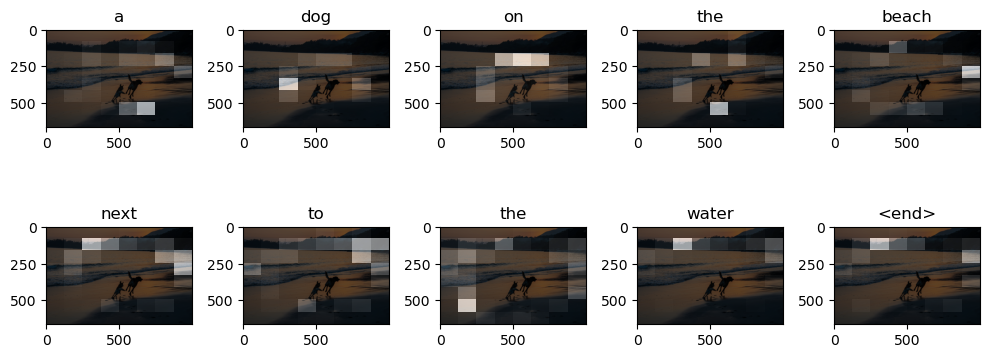

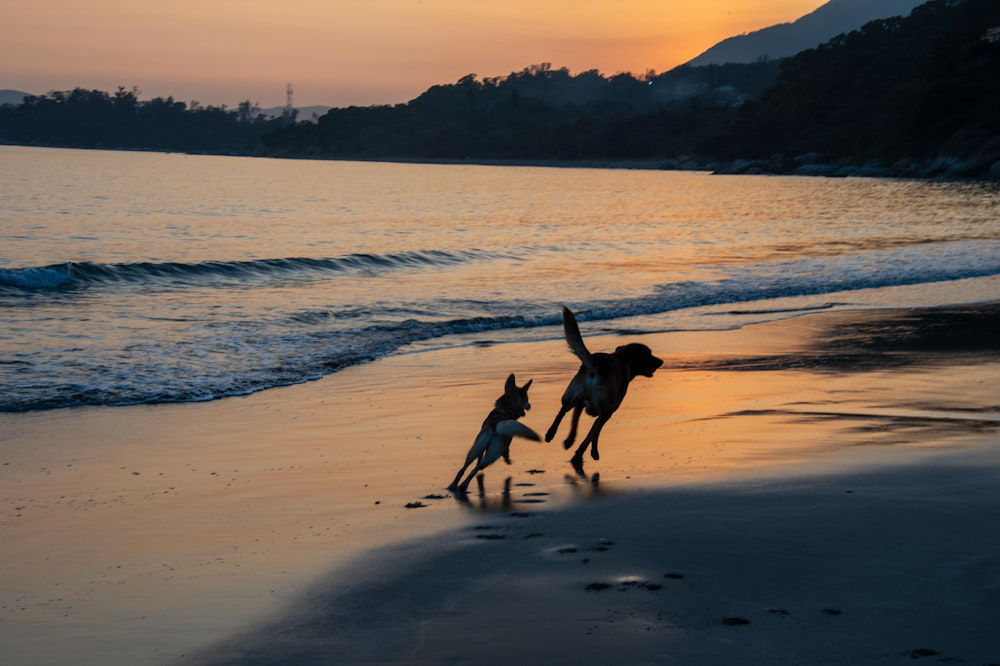

In [79]:
#image_url = 'https://www.hillspet.com/content/dam/cp-sites/hills/hills-pet/en_us/exported/dog-care/Skyword/images/two-dogs-on-beach-at-sunset-SW.jpg'
image_url = 'https://images.unsplash.com/photo-1647479458842-8b39b20758d0?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1yZWxhdGVkfDExfHx8ZW58MHx8fHx8&w=1000&q=80'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)
        
result, attention_plot = evaluate(image_path)
print ('Prediction caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

# opening the image and compare translation with the image itself
Image.open(image_path)

# Conclusion
The integration of Convolutional Neural Networks (CNNs) with Recurrent Neural Networks (RNNs) and Bahdanau Attention has proven to be a powerful approach for image captioning. Through this project, I have successfully developed a model capable of generating descriptive and contextually relevant captions for images.

By leveraging CNNs, model effectively extracts meaningful features from images, enabling it to understand the visual content. The incorporation of RNNs allows for the generation of sequential text, ensuring that the generated captions are coherent and correct. Additionally, the integration of Bahdanau Attention provides the model with the ability to dynamically focus on different parts of the image, enhancing the relevance and detail of the generated captions.